In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
tf.__version__

'2.8.0'

In [4]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        #배열의 짝수 인덱스(2i) 에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        
        #배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


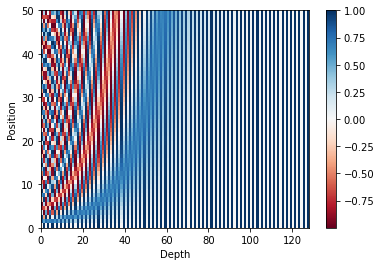

In [6]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [7]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key문장 길이)
    
    # Q와 K의 곱 / 어텐션 스코어 행렬
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)
        
    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query 문장 길이, key 문장 길이)
    attention_weights = tf.nn.sorfmax(logits, axis=-1)
    
    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)
    
    return output, attention_weights

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        # d_model을 num_heads 로 나눈 값
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads == 0
        
        # WQ, WK, WV 에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)
        
        # num_heads 개수만큼 q, k, v를 split 하는 함수
        def split_heads(self, inputs, batch_size):
            inputs = tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth))
            return tf.transpose(inputs, perm=[0, 2, 1, 3])
        
        def call(self, inputs):
            query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
            batch_size = tf.shape(query)[0]
            
            # 1. WQ, WK, WV에 해당하는 밀집층 지나기
            # q : (batch_size, query의 문장 길이, d_model)
            # k : (batch_size, key의 문장 길이, d_model)
            # v : (batch_size, value의 문장 길이, d_model)
            # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value 길이는 다를 수 있다.
            query = self.query_dense(query)
            key = self.key_dense(key)
            value = self.value_dense(value)
            
            # 2. 헤드 나누기
            # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
            # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
            # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
            query = self.split_heads(query, batch_size)
            key = self.split_heads(key, batch_size)
            value = self.split_heads(value, batch_size)
            
            # 3. 스케일드 닷 프로둭트 어텐션. 앞서 구현한 함수 사용.
            # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
            scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
            # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
            scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
            
            # 4. 헤드 연결(concatenate)하기
            # (batch_size, query의 문장 길이, d_model)
            concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
            
            # 5. WO에 해다와는 밀집층 지나기
            # (batch_size, query 의 문장 길이, d_model)
            outputs = self.dense(concat_attention)
            
            return outputs

In [11]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer")
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    
    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    #멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs, 'key' : inputs, 'value': inputs, #Q = K = V
        'mask' : padding_mask #패딩 마스크 사용
    })
    # 드롭아웃 + 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon = le-6)